In [ ]:
########################################################################
# Author    : A. Alsema
# Date      : April 2022
# Dataset   : Visium Spatial Transcriptomics for MS lesions, 15 slices with WM 
# Purpose   : CDS contains only 4000 genes, 
# but we would like to add all gene expression info to monocle's CDS 
# before extracting subtrajectories and before differential expression analysis

# Required Inputs: 
# - cds object including trajectory: "2.monocle_traj_WM.rds", see figure 5 script 1
# - count table: "expr_matrix.mtx", see figure 5 script 0
# - corresponding gene symbols: "expr_matrix_genes.tsv", see figure 5 script 0

# Output: cds object ready for subsetting or differential expression analysis: "3.monocle_traj_WM_allgenes.rds"
########################################################################

In [1]:
rm(list = ls())
library(monocle3)
library(ggplot2)
library(dplyr)
library(Matrix)
require(readr)

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading

In [2]:
indir = "RData/monocle3/"
outdir = "Routput/monocle3/trajectory_DE/"
# load trajectory data
cds = readRDS(paste0(indir, "2.monocle_traj_WM.rds"))
dim(cds) # this does not contain all genes

[1]  4000 55084

In [3]:
# we would like to run DE on all genes, not just the top 4000 genes.
# load full counts
counts <- readMM(file = paste0(indir,"expr_matrix.mtx")) # this takes some minutes!
genes <- read_tsv(file = paste0(indir, "expr_matrix_genes.tsv"), col_names = F)
rownames(counts) <- genes$X1
genes_ids <- as.data.frame(genes, row.names = genes$X1)
colnames(genes_ids)[1] <- "gene_short_name"
rownames(genes_ids) <- genes$X1
head(genes_ids)

Rows: 33538 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): X1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


,gene_short_name
,<chr>
MIR1302-2HG,MIR1302-2HG
FAM138A,FAM138A
OR4F5,OR4F5
AL627309.1,AL627309.1
AL627309.3,AL627309.3
AL627309.2,AL627309.2


In [5]:
cell_ids <- read_tsv(file = paste0(indir, "expr_matrix_barcodes.tsv"), col_names = F)$X1
colnames(counts) <- cell_ids

Rows: 55084 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): X1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
meta <- as.data.frame(colData(cds))
### Construct the basic cds object with all genes
cds_full <- new_cell_data_set(counts,
                                     cell_metadata = meta,
                                     gene_metadata = genes_ids)

'as(<dgTMatrix>, "dgCMatrix")' is deprecated.
Use 'as(., "CsparseMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").



In [7]:
### Construct and assign the made up partition (not used)
recreate.partition <- c(rep(1, length(cds_full@colData@rownames)))
names(recreate.partition) <- cds_full@colData@rownames
recreate.partition <- as.factor(recreate.partition)
cds_full@clusters@listData[["UMAP"]][["partitions"]] <- recreate.partition
### Could be a space-holder, but essentially fills out louvain parameters (Seurat part)
cds_full@clusters@listData[["UMAP"]][["louvain_res"]] <- "NA"

In [18]:
#----------------------------------------------------------------------#
## move graph info and dim red to new cds objects (monocle3 part)
## Assign UMAP coordinate
reducedDims(cds_full)$UMAP <- reducedDims(cds)$UMAP
cds_full@reduce_dim_aux <- cds@reduce_dim_aux # for real DE do on all genes
cds_full@principal_graph <- cds@principal_graph #
cds_full@clusters <- cds@clusters
cds_full@principal_graph_aux <- cds@principal_graph_aux

Cells aren't colored in a way that allows them to be grouped.



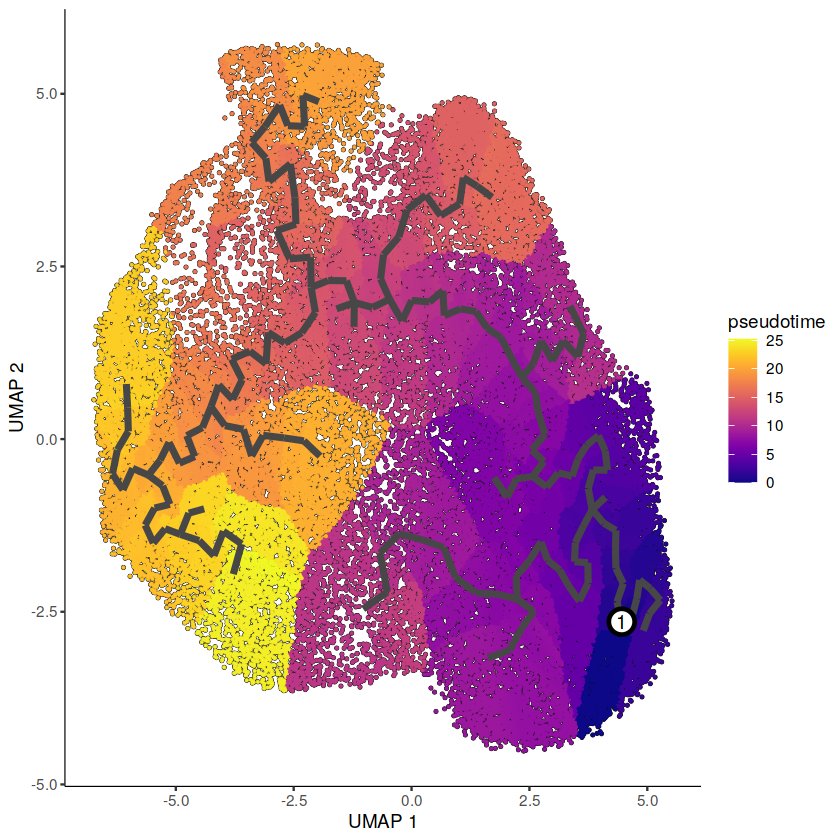

In [19]:
plot_cells(cds_full,
                   cell_size = 0.5,
                   color_cells_by = "pseudotime",
                   label_groups_by_cluster=FALSE,
                   label_leaves=FALSE,
                   label_roots = TRUE,
                   label_branch_points=FALSE,
                   trajectory_graph_segment_size = 1.5,
                   graph_label_size= 4)

In [20]:
saveRDS(cds_full, file = paste0(indir, "3.monocle_traj_WM_allgenes.rds"))